In [1]:
import numpy as np
import pandas as pd
import os
import re
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# Paramétrage de l'affichage des dataframes
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', None)

In [2]:
# Détermination du temps de vieillissement à partir du nom de fichier
def age(parameters):
    compound_mapping = {
        '240208': 349,
        '240308': 378,
        '240405': 406,
        '240503': 434,
        '240607': 462,
        'frais': 0
    }
    
    for key, value in compound_mapping.items():
        if key in parameters:
            return value
    return 0

In [3]:
# Indiquer emplacement des données
directory =

dataframes = []
tapes = []
triplicats = []
filenames = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        
        try:
            df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                             dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                             index_col='Ret.Time', decimal=',', encoding='utf-8')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='latin1')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='cp1252')

        parameters = re.split(r'[-._ ]', filename)
        tapes.append(parameters[0])
        triplicats.append(parameters[-2])
        filenames.append(filename)
        dataframes.append(df)

data = pd.concat(dataframes, axis=1)
data = data.loc[:, ~data.columns.str.contains('Relative Intensity')]
data = data.T.reset_index(drop=True).rename_axis('Index')

data['tape'] = tapes
data['triplicat'] = triplicats
data['file name'] = filenames

cols = list(data.columns)
cols = ['tape'] + [col for col in cols if col != 'tape']
data = data[cols]

data.sort_values(by=['tape', 'triplicat'], inplace=True)
data.reset_index(drop=True, inplace=True)

data

Ret.Time,tape,1.1,1.102,1.103,1.105,1.107,...,38.993,38.995,38.997,38.998,triplicat,file name
0,raa12,49632,49448,49973,50043,48073,...,91993,93052,93050,94260,1,raa12_frais_triplicat_1.txt
1,raa12,45885,46208,48241,49222,47604,...,113922,111604,110577,109951,2,raa12_frais_triplicat_2.txt
2,raa12,54134,55483,55685,54256,54599,...,132989,132600,134211,138347,3,raa12_frais_triplicat_3.txt
3,raa13,46436,46321,46587,46225,45889,...,122333,123216,124121,121920,1,raa13_frais_triplicat_1.txt
4,raa13,39937,40786,42240,42346,42186,...,119198,120005,121997,123933,2,raa13_frais_triplicat_2.txt
5,raa13,49139,48384,48682,50700,50744,...,231707,230517,230430,230058,3,raa13_frais_triplicat_3.txt
6,raa14,50714,50472,50044,50155,50226,...,94218,94226,94429,93861,1,raa14_frais_triplicat_1.txt
7,raa14,43303,42518,42181,41690,41964,...,90256,91464,92612,93302,2,raa14_frais_triplicat_2.txt
8,raa14,39217,39809,41275,41617,42740,...,125001,124479,126165,127227,3,raa14_frais_triplicat_3.txt
9,raa15,56059,56914,57288,55435,55648,...,78613,79569,79977,79887,1,raa15_frais_triplicat_1.txt


In [4]:
# Les données n'étant pas rigoureusement collectées touttes les 0.001 min,
# seules les colonnes finissant en 0.000 ou 0.005 sont conservées,
# afin de permettre de décaler les chromato pour les supperposer
selected_columns = [col for col in data.columns[1:-2] if str(col).endswith(('5', '0'))]
data_selected = data.loc[:, ['tape'] + list(selected_columns) + ['triplicat', 'file name']]

data_selected

Ret.Time,tape,1.105,1.115,1.125,1.135,1.145,...,38.965,38.975,38.985,38.995,triplicat,file name
0,raa12,50043,49241,46186,46748,46138,...,91979,90588,91250,93052,1,raa12_frais_triplicat_1.txt
1,raa12,49222,48884,43901,46707,45603,...,111789,110011,110175,111604,2,raa12_frais_triplicat_2.txt
2,raa12,54256,53811,54373,56492,52363,...,136788,132897,135860,132600,3,raa12_frais_triplicat_3.txt
3,raa13,46225,48243,44519,46311,47107,...,119002,121758,125068,123216,1,raa13_frais_triplicat_1.txt
4,raa13,42346,42578,40699,38757,40281,...,115411,119073,116402,120005,2,raa13_frais_triplicat_2.txt
5,raa13,50700,47564,50968,48707,48166,...,217135,220907,226609,230517,3,raa13_frais_triplicat_3.txt
6,raa14,50155,49864,47165,47880,47371,...,95114,97053,95202,94226,1,raa14_frais_triplicat_1.txt
7,raa14,41690,41329,43210,44010,42951,...,89360,92327,92099,91464,2,raa14_frais_triplicat_2.txt
8,raa14,41617,40982,42144,40370,40021,...,127137,124517,124386,124479,3,raa14_frais_triplicat_3.txt
9,raa15,55435,55132,56675,54129,53900,...,81709,81455,80384,79569,1,raa15_frais_triplicat_1.txt


In [6]:
# Défini les décallages pour chaque chromatogramme
shift_values = {
    'raa12': {'1': -0.02, '2': -0.015, '3': -0.020},
    'raa13': {'2': -0.00, '3': -0.05},
    'raa14': {'1': -0.03, '2': -0.03, '3': -0.02},
    'raa15': {'2': -0.00, '3': +0.005},
    'raa16': {'2': -0.00, '3': -0.02}
}

# Converti le décallage temporel en décallage de colonnes
def convert_shifts_to_columns(shift_values, step_size):
    column_shifts = {}
    for tape, triplicat_shifts in shift_values.items():
        column_shifts[tape] = {triplicat: int(shift / step_size) for triplicat, shift in triplicat_shifts.items()}
    return column_shifts
step_size = 0.002
column_shifts = convert_shifts_to_columns(shift_values, step_size)

# Décale les données dans le dataframe
def shift_columns(data, column_shifts):
    non_numeric_cols = ['tape', 'triplicat', 'file name']
    numeric_data = data.drop(columns=non_numeric_cols)
    shifted_data = numeric_data.transpose()  # Transpose the numeric part of the DataFrame
    for idx, row in data.iterrows():
        tape = row['tape']
        triplicat = row['triplicat']
        if tape in column_shifts and triplicat in column_shifts[tape]:
            shift = column_shifts[tape][triplicat]
            shifted_data[idx] = shifted_data[idx].shift(periods=-shift)
    
    shifted_numeric_data = shifted_data.transpose()  # Transpose it back
    # Combine the 'tape' column with the shifted numeric data
    final_data = pd.concat([data[['tape']], shifted_numeric_data], axis=1)
    # Add 'age' and 'file name' columns back in the end
    final_data = pd.concat([final_data, data[['triplicat', 'file name']]], axis=1)
    return final_data

In [7]:
# Applique le décalage
data_shifted = shift_columns(data, column_shifts)

data_raa12_shifted = data_shifted[data_shifted["tape"]=="raa12"]
data_raa13_shifted = data_shifted[data_shifted["tape"]=="raa13"]
data_raa14_shifted = data_shifted[data_shifted["tape"]=="raa14"]
data_raa15_shifted = data_shifted[data_shifted["tape"]=="raa15"]
data_raa16_shifted = data_shifted[data_shifted["tape"]=="raa16"]

In [8]:
# Représente le chromatogramme, avec possibilité de réduire la plage temporelle,
# et d'afficher les pics identifiés.
def plot_TIC(data_plot_spectra, start_time=None, end_time=None, found_tr=None):
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    data_to_plot = data_plot_spectra.values[:, 1:-3]

    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]

    plt.figure(figsize=(12, 4))
    cmap = cm.coolwarm(np.linspace(0, 0.8, len(data_filtered)))

    for row in range(len(data_filtered)):
        Int = data_filtered[row]
        color = cmap[row]
        triplicat = data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('triplicat')]
        if triplicat == 0:
            color = 'black'
            label = 'Triplicat: 0'
        else:
            label = f'Triplicat: {triplicat}'
        plt.plot(Tr_filtered, Int, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)
    
    if found_tr is not None:
            plt.axvline(x=found_tr, color='black', linestyle='--', linewidth=1, label=f'Found TR: {found_tr}')
    
    plt.xlabel('Temps de rétention (min)')
    plt.ylabel('Intensité')
    plt.legend()
    plt.show()

# Représente les chromatrogrammes avec un décalage vertical
def plot_with_vshift(data, vshift, start_time=None, end_time=None, found_tr=None):
    data2 = data.copy()
    numeric_columns = data.columns[1:-3]  # Assuming columns from the second to the third last
    i = 1
    for idx, row in data.iterrows():
        data2.loc[idx, numeric_columns] = row[numeric_columns].astype(float) + i*vshift
        i += 1
    return data2

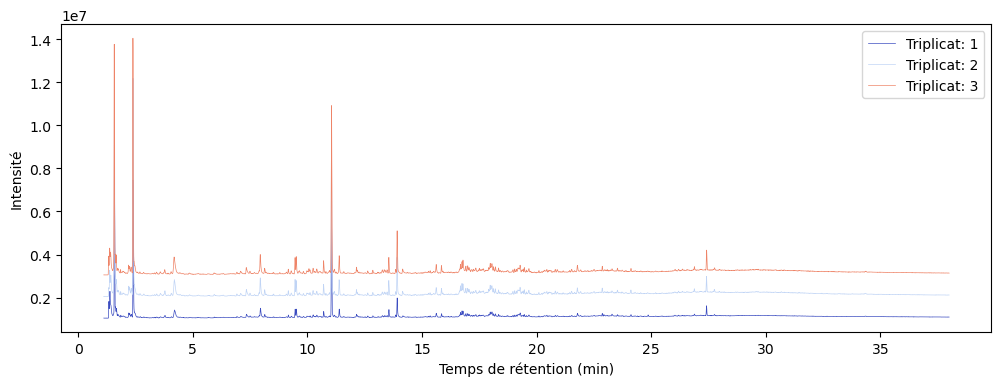

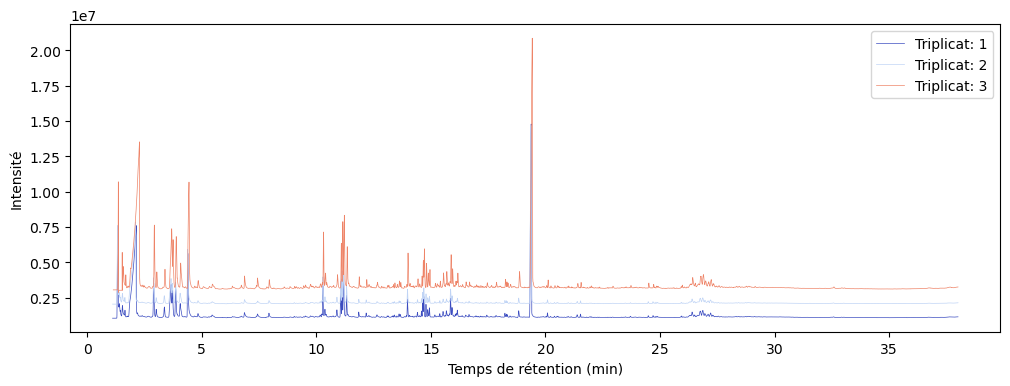

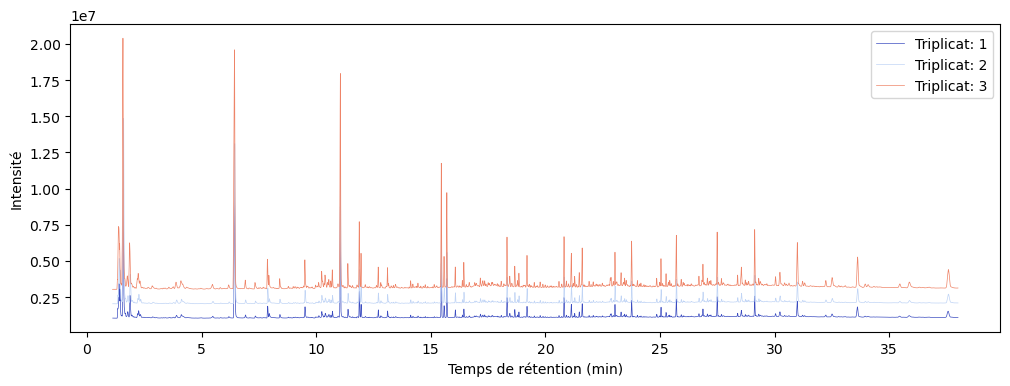

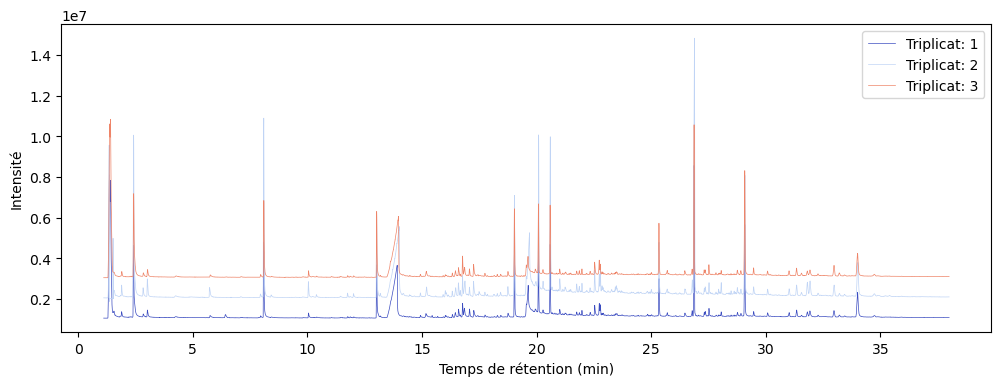

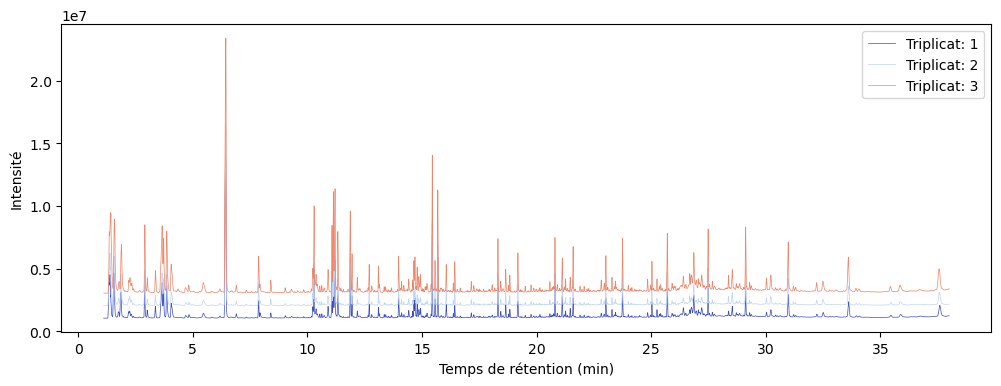

In [9]:
datadata_raa12_vshifted = plot_with_vshift(data_raa12_shifted, 1000000)
datadata_raa13_vshifted = plot_with_vshift(data_raa13_shifted, 1000000)
datadata_raa14_vshifted = plot_with_vshift(data_raa14_shifted, 1000000)
datadata_raa15_vshifted = plot_with_vshift(data_raa15_shifted, 1000000)
datadata_raa16_vshifted = plot_with_vshift(data_raa16_shifted, 1000000)

plot_TIC(datadata_raa12_vshifted, 1.11, 38)
plot_TIC(datadata_raa13_vshifted, 1.11, 38)
plot_TIC(datadata_raa14_vshifted, 1.11, 38)
plot_TIC(datadata_raa15_vshifted, 1.11, 38)
plot_TIC(datadata_raa16_vshifted, 1.11, 38)

## Data processing

In [11]:
# Définition des fonctions utilisées pour le calcul des intensités
# Ajustement des paramètres de recherche des pics manuellement
def closest_inferior_value(value, value_list):
    closest = None
    for v in value_list:
        if v < value:
            if closest is None or value - v < value - closest:
                closest = v
    return closest

# Ajuste le temps de rétention
def find_max_intensity(df, row, retention_time, window=0.1):
    
    if df.loc[row, 'tape'] == 'raa12':
        if retention_time > 4:
            if retention_time < 4.5:
                window = 0.2
        if retention_time > 16.6:
            if retention_time < 16.7:
                window = 0.03
    
    if df.loc[row, 'tape'] == 'raa13':
        if retention_time > 4.3:
            if retention_time < 4.6:
                window = 0.2
        if retention_time > 7:
            if retention_time < 7.5:
                window = 0.2
        if retention_time > 19:
            if retention_time < 19.5:
                window = 0.2
        if df.loc[row, 'triplicat'] == '3':
            if retention_time > 2.5:
                if retention_time < 3.7:
                    window = 0.05
            if retention_time > 3.7:
                if retention_time < 3.8:
                    window = 0.02
            if retention_time > 3.8:
                if retention_time < 4:
                    window = 0.05
            if retention_time > 10.31:
                if retention_time < 10.5:
                    window = 0.04
            if retention_time > 11:
                if retention_time < 11.3:
                    window = 0.05
            if retention_time > 11.4:
                if retention_time < 12.5:
                    window = 0.2
            if retention_time > 13.5:
                if retention_time < 14.1:
                    window = 0.2
            if retention_time > 14.5:
                if retention_time < 14.6:
                    window = 0.05
            if retention_time > 14.9:
                if retention_time < 15:
                    window = 0.1
            if retention_time > 15:
                if retention_time < 15.9:
                    window = 0.1
            if retention_time > 15.9:
                if retention_time < 18.25:
                    window = 0.1
            if retention_time > 18.4:
                if retention_time < 19:
                    window = 0.1
            if retention_time > 20:
                if retention_time < 30:
                    window = 0.2
            
    if df.loc[row, 'tape'] == 'raa14':
        if retention_time > 1:
            if retention_time < 2:
                window = 0.1
        if retention_time > 2:
            if retention_time < 2.5:
                window = 0.025
        if retention_time > 6:
            if retention_time < 7.5:
                window = 0.1
        if retention_time > 7.5:
            if retention_time < 7.9:
                window = 0.05
        if retention_time > 7.9:
            if retention_time < 8:
                window = 0.01
        if retention_time > 8.2:
            if retention_time < 10:
                window = 0.1
        if retention_time > 11.8:
            if retention_time < 11.9:
                window = 0.1
    
    if df.loc[row, 'tape'] == 'raa15':
        if retention_time > 1:
            if retention_time < 2:
                window = 0.1
        if retention_time > 8:
            if retention_time < 13.5:
                window = 0.1
        if retention_time > 19.5:
            if retention_time < 20:
                window = 0.1
        if retention_time > 32:
            if retention_time < 35:
                window = 0.1
    
    if df.loc[row, 'tape'] == 'raa16':
        if retention_time > 3.7:
            if retention_time < 3.8:
                window = 0.05
                
    retention_times = df.columns[10:-100].astype(float)
    start_time = closest_inferior_value(retention_time - window, retention_times)
    end_time = closest_inferior_value(retention_time + window, retention_times)
    max_intensity = df.loc[row, start_time:end_time].max()
    max_retention_time = df.loc[row, start_time:end_time].idxmax()

    return max_intensity, max_retention_time


def relative_intensity(df, row, retention_time_1, retention_time_2):    
    I_peak = find_max_intensity(df, row, retention_time_1)[0]
    ref_peak = find_max_intensity(df, row, retention_time_2)[0]
    return I_peak / ref_peak

In [12]:
# Recherche tous les pics au dessus d'une valeur seuil
def find_peak_rt(df, row, start, end, threshold):
    Tr = df.columns[1:-3].astype(float)
    intensity_values = df.iloc[row, 1:-3].values
    derivate = np.gradient(intensity_values)
    
    # Filter the retention times and intensities based on start and end
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered = Tr[start_idx:end_idx]
    intensity_filtered = intensity_values[start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]

    # Step 1: Find peaks using find_peaks
    peaks, _ = find_peaks(intensity_filtered, height=threshold)
    
    # Step 2: Find the retention time where the derivative crosses 0 closest to the found peaks
    zero_crossings = np.where(np.diff(np.sign(derivate_filtered)))[0]
    peak_rts = []
    peak_rts2 = []
    
    for peak_idx in peaks:
        peak_ret_time = Tr_filtered[peak_idx]
        closest_zero_crossing_idx = np.argmin(np.abs(Tr_filtered[zero_crossings] - peak_ret_time))
        closest_zero_crossing = zero_crossings[closest_zero_crossing_idx]
        peak_rts.append(Tr_filtered[closest_zero_crossing])
        peak_rts2.append(Tr_filtered[peak_idx])
    
    return peak_rts

In [13]:
# Détermine l'étalement du pic
# Ajustement manuel
def find_peak_range(df, row, start, end, peak):
    if df.loc[row, 'tape'] == 'raa12':
        if peak > 7:
            if peak < 7.2:
                return 7.025, 7.17
        if peak > 7.2:
            if peak < 7.4:
                return 7.28, 7.43
        if peak > 16:
            if peak < 16.5:
                return 16.23, 16.33
        if peak > 21:
            if peak < 22:
                return 21.74, 21.83
        
    if df.loc[row, 'tape'] == 'raa13':
        if peak > 1:
            if peak < 2.5:
                return 1.8, 2.3  
        if peak > 6.5:
            if peak < 7:
                return 6.815, 7
        if peak > 7:
            if peak < 7.5:
                return 7.41, 7.6
        if peak > 7.5:
            if peak < 8:
                return 7.9, 8.05
        if df.loc[row, 'triplicat'] == '3':
            if peak > 15.9:
                if peak < 16:
                    return 15.92, 16
            if peak > 26.7:
                if peak < 26.82:
                    return 26.73, 26.84
            if peak > 26.81:
                if peak < 26.92:
                    return 26.84, 26.95
        if peak > 26.7:
            if peak < 26.81:
                return 26.7, 26.81
        if peak > 26.81:
            if peak < 26.92:
                return 26.81, 26.92

    if df.loc[row, 'tape'] == 'raa14':
        if df.loc[row, 'triplicat'] == '3':
            if peak > 2.1:
                if peak < 2.22:
                    return 2.14, 2.21
            if df.loc[row, 'triplicat'] == '1':
                if peak > 7.94:
                    if peak < 8.05:
                        return 7.94, 8.05
            if df.loc[row, 'triplicat'] == '2':
                if peak > 7.94:
                    if peak < 8.05:
                        return 7.94, 8.05
        
    if df.loc[row, 'tape'] == 'raa15':
        if peak > 13.5:
            if peak < 14:
                return 13.45, 14.05
        if peak > 32.9:
            if peak < 33.05:
                return 32.9, 33.05
    
    if df.loc[row, 'tape'] == 'raa16':
        if peak > 4:
            if peak < 4.1:
                return 4.01, 4.08
        if peak > 4.1:
            if peak < 4.2:
                return 4.08, 4.19
        if peak > 10.2:
            if peak < 10.255:
                return 10.2, 10.255

    Tr = df.columns[1:-3].astype(float)
    intensity_values = df.iloc[row, 1:-3].values
    derivate = np.gradient(intensity_values)
    
    new_peak = find_max_intensity(df, row, peak, window=0.02)[1]
    peak = new_peak
                                                              
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered = Tr[start_idx:end_idx]
    intensity_filtered = intensity_values[start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]
    
    peak_index = np.searchsorted(Tr_filtered, peak)
    start = None
    i = 2
    while start == None:
        if derivate_filtered[peak_index-i] <= 0:
            start = peak_index-i
        i += 1
    end = None
    i = 2
    while end == None:
        if derivate_filtered[peak_index+i] >= 0:
            end = peak_index+i
        i += 1
    start_tr = Tr_filtered[start]
    end_tr = Tr_filtered[end]

    return start_tr, end_tr

[[13.54, 13.503, 13.595], [13.902, 13.865, 13.988]]


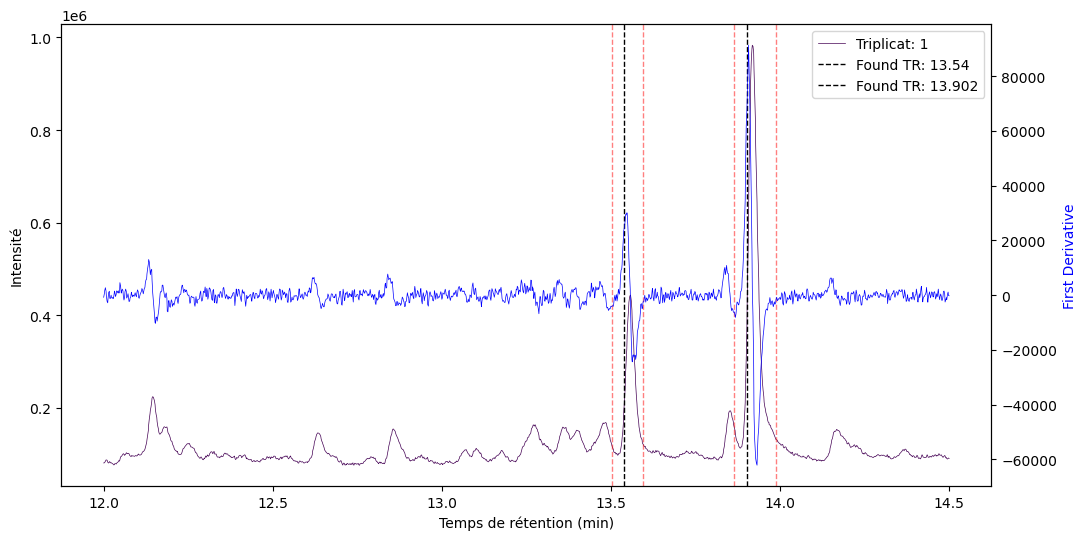

In [14]:
# Illustration de comment sont trouvés les maximums et bases des pics
def plot_TIC_with_derivate(data_plot_spectra, row=None, start_time=None, end_time=None, peaks_info=None):
    # Extract retention times and intensities
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    if row is not None:
        intensity_values = data_plot_spectra.iloc[row, 1:-3].values
        data_to_plot = np.array([intensity_values])
        derivate = np.gradient(intensity_values)
    else:
        data_to_plot = data_plot_spectra.values[:, 1:-3]

    # Filter columns based on the specified start and end retention times
    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    cmap = cm.viridis(np.linspace(0, 0.8, len(data_filtered)))

    for row in range(len(data_filtered)):
        Int = data_filtered[row]
        color = cmap[row]
        triplicat = data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('triplicat')]
        if triplicat == 0:
            color = 'red'
            label = 'Triplicat: 0'
        else:
            label = f'Triplicat: {triplicat}'
        ax1.plot(Tr_filtered, Int, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)
    
    if peaks_info is not None:
        for peak_info in peaks_info:
            peak_rt, start_rt, end_rt = peak_info

            ax1.axvline(x=peak_rt, color='black', linestyle='--', linewidth=1, label=f'Found TR: {peak_rt}')
            ax1.axvline(x=start_rt, color='red', linestyle='--', linewidth=1, alpha=0.5)
            ax1.axvline(x=end_rt, color='red', linestyle='--', linewidth=1, alpha=0.5)

    ax1.set_xlabel('Temps de rétention (min)')
    ax1.set_ylabel('Intensité')
    ax1.legend()
    
    ax2 = ax1.twinx()

    ax2.plot(Tr_filtered, derivate_filtered, color='blue', linestyle='-', linewidth=0.5, alpha=1)
    ax2.set_ylabel('First Derivative', color='blue')
    
    plt.show()

peaks_info = []
peak_rts = find_peak_rt(data, 0, 12, 14.5, 250000)
for peak in peak_rts:
    peak_info = []
    peak_info.append(peak)
    peak_info.append(find_peak_range(data, 0, 12, 14.5, peak)[0])
    peak_info.append(find_peak_range(data, 0, 12, 14.5, peak)[1])
    peaks_info.append(peak_info)

print(peaks_info)

plot_TIC_with_derivate(data_shifted[:], row=0, start_time=12, end_time=14.5, peaks_info=peaks_info)

In [15]:
# Calcul de l'air d'un pic
def peak_area(df, row, start, end):
    Tr = df.columns[1:-3].astype(float)
    intensity_values_a = df.iloc[row, 1:-3].values
    
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered_a = Tr[start_idx:end_idx]
    intensity_filtered_a = intensity_values_a[start_idx:end_idx]
    
    baseline_start = intensity_filtered_a[0]
    baseline_end = intensity_filtered_a[-1]
    baseline_min = min(baseline_start, baseline_end)
    baseline = np.linspace(baseline_min, baseline_min, len(Tr_filtered_a))
    
    area = np.trapz(intensity_filtered_a, Tr_filtered_a)*60
    
    return area, Tr_filtered_a, intensity_filtered_a, baseline

## Plot

In [17]:
# Définition des temps de rétention approximatifs, des noms de composés et de leur catégorie

# RAA12
retention_times_raa12 = [4.195, 7.09, 7.34, 7.95, 8.14, 9.47, 9.52, 10.71, 11.06, 11.39,
                         
                         13.56, 13.92, 14.15, 15.62, 15.85, 16.27, 16.69, 16.75, 16.79, 16.92, 
                         
                         17, 17.98, 18.06, 18.13, 18.2, 19.28, 19.47, 21.78, 22.87, 26.89, 
                         
                         27.22, 27.42, 28.02]

compounds_raa12 = ['Toluene', 'Ethyl benzene', 'm-xylene', 'Styrene', 'C9H14', 'C10H16', '2,4-dimethl-4-vinylcyclohexene', 
                   '2,5-dimethyl-3-methylene-1,5-heptadiene', 'D-limonene', 'Indene', 
                   
                   '1-methylindene', 'Napthalene', 'Isothiocyanatobenzene', '2-methylnaphtalene', '1-methylnaphtalene', 
                   'o-ter-butyk-o-cresol', '?', 'C14H28', 'Acenaphtene', '?',
                   
                   '?', '?', '?', '?', '?', '?', 'Fluorene', 'Anthracene', 'C15H24', '?', 
                   
                   '?', 'Advastab', '?']

compound_types_raa12 = ['Backing or adhesive', 'Backing', 'Backing or adhesive', 'Backing', 'Alkene', 'Alkene', 'Adhesive', 
                        'Adhesive', 'Adhesive', 'Backing', 
                        
                        'Backing', 'Backing', 'Additive', 'Backing', 'Backing', 'Additive', 'Alkene', 'Alkene', 'Backing', 
                        'Alkene', 
                        
                        'Alkene', 'Alkene', 'Alkene', 'Unknown', 'Mix', 'Alkene', 'Backing', 'Backing', 'Alkene', 'Unknown', 
                        
                        'Alkane', 'Additive', 'Alkane']

compound_types_plot_raa12 = ['Backing', 'Backing or adhesive', 'Adhesive', 'Additive', 'Alkene', 'Alkane', 'Mix', 'Unknown']


# RAA13
retention_times_raa13 = [2.15, 2.9, 3.02, 3.26, 3.37, 3.66, 3.73, 3.86, 4.06, 4.42,
                         
                        4.83, 6.85, 7.41, 7.93, 10.3, 10.38, 10.91, 11.08, 11.13, 11.2,
                         
                        11.33, 11.85, 12.18, 12.51, 13.61, 13.98, 14.42, 14.59, 14.65, 14.7,
                         
                        14.79, 14.87, 14.93, 15.39, 15.52, 15.67, 15.85, 15.92, 16.15, 16.51,
                         
                        18.22, 18.29, 18.83, 19.35, 20.09, 26.4, 26.76, 26.87, 27.21]

compounds_raa13 = ['Acetic acid', '3,5-dimethylhex-1-ene', 'Methyl methacrylate', 'Acetic anhydride', '4-methylheptan-1-ol',
                  'C8H16', 'C8H16', 'C8H16', '5-methylhept-1-ene', '2-hydroxyethyl acetate',
                  
                  'oct-1-ene', '?', 'Acetoxyacetone', 'Styrene', '6-methylheptan-1-ol', 'Furfuryl acetate',
                  '3-ethyl-4-methyl-1-pentanol', '?', '3-methylheptan-1-ol', '4-methylheptan-1-ol',
                  
                  '5-methylheptan-1-ol', 'Octan-1-ol', '?', '?', 'Ethyl benzoate', 'Octyl prop-2-enoate', '?', '?', '?',
                  'Ethylene, diacrylate',
                  
                  'Octyl acrylate', '?', 'C8H18O', '?', '?', '5-Acetoxymethyl-2-furaldehyde', 'Phthalic anhydridre', '?', '?', '?',
                   
                  '?', '2,6-di-tert-butylphenol', '?', 'DEP', '?', '?', '?', '?', '?']

compound_types_raa13 = ['Backing', 'Alkene', 'Adhesive', 'Backing', 'Alcohol', 'Alkene', 'Alkene', 'Alkene', 'Alkene', 'Backing',
                      
                      
                      'Alkene', 'Backing', 'Alkene', 'Backing', 'Ester', 'Aromatic', 'Alcohol', 'Terpene', 'Alcohol',
                      'Alcohol',
                      
                      'Alcohol', 'Alcohol', 'Alcohol', 'Alcohol', 'Ester', 'Ester', 'Ester', 'Ester', 'Ester', 'Ester',
                      
                      'Ester', 'Ester', 'Alcohol', 'Ester', 'Unknown', 'Ester', 'Additive', 'Backing', 'Backing', 'Backing',
                      
                      'Backing', 'Additive', 'Ester', 'Additive', 'Backing', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

compound_types_plot_raa13 = ['Backing', 'Adhesive', 'Additive', 'Alcohol', 'Alkene' ,'Ester', 'Aromatic', 
                             'Terpene', 'Unknown']


# RAA14
retention_times_raa14 = [1.87, 2.2, 2.24, 2.33, 6.46, 7.89, 7.95, 8.42, 9.52, 
                         
                         10.25, 10.39, 10.71, 11.04, 11.38, 11.86, 11.97, 12.71, 13.12, 15.46,
                         
                         15.58, 15.7, 16.08, 16.44]

compounds_raa14 = ['2-methyl-1-pentene', '?', '?', '?', '2,4-dimethylhept-1-ene', '2,4,6-trimethyl-1,6-heptadiene', 'Styrene',
                   '2,4,6-trimethyl-1,6-heptadiene', '2,4-dimethyl-4-vinylcyclohexene',
                   
                   '4,6-dimethyl-2-nonene', '?', '2-5-dimethyl-3-methylene-1,5-heptadiene', 'D-limonene', '?',
                   '2,4,6-trimethylnon-1-ene meso', '2,4,6-trimethylnon-1-ene racemic', '2,4,6,8-tetramethyl-1-nonene?',
                   '2,4,6,8-tetramethyl-1,8-nondiene?', '2,4,6,8-tetramethylundec-1-ene isotactic',
                   
                   '2,4,6,8-tetramethylundec-1-ene heterotactic', '2,4,6,8-tetramethylundec-1-ene syndiotactic', '2,4,6,8,10-pentamethylundec-1-ene isotactic', 
                   '2,4,6,8,10-pentamethylundecadi-1-ene isotactic']

compound_types_raa14 = ['Backing', 'Backing', 'Backing', 'Backing', 'Backing', 'Backing', 'Adhesive', 'Backing', 'Adhesive',
                        
                        'Backing', 'Alkene', 'Adhesive', 'Adhesive', 'Aromatic', 'Backing', 'Backing', 'Backing', 'Backing', 'Backing',
                        
                        'Backing', 'Backing', 'Backing', 'Backing']

compound_types_plot_raa14 = ['Backing', 'Adhesive', 'Alkene', 'Aromatic']


# RAA15
retention_times_raa15 = [1.98, 2.43, 3.03, 8.12, 10.07, 13.05, 13.9, 16.79, 16.87, 17.08, 
                         
                         17.27, 19.05, 19.66, 20.1, 20.61, 21.03, 22.55, 22.75, 22.8, 25.35, 
                         
                         26.81, 26.88, 27.54, 28.07, 29.1, 32.99, 34.03]

compounds_raa15 = ['Butanal', '1-butanol / Benzene', 'Methyl metacrylate (MMA)', 'n-butyl acrylate', 
                   'n-butyl metacrylate (BMA)', 'Vinyl benzoate', 'Benzoic acid',
                   'Biphenyl', '4-Vinylbenzoic acid', '2-chloroethylbenzoate', 
                   
                   '2-hydroxyethylbenzoate ?', 'Divinyl terephtalate', '4-(vinyloxycarbonyl) benzoic acid', 'C13H24O4 ?', '?', '?', '?', '?', '?', 
                   '1,2-Ethanediol, dibenzoate',
                   
                   '?', 'terephthalic acid, di-2-chloroethyl ester ?', '?', '?', '2-(benzoyloxy)ethyl vinyl terephtalate ?', '?', 
                   'ethan-1,2-diyl divinyl diterephtalate']

compound_types_raa15 = ['Aldehyde', 'Mix', 'Adhesive', 'Adhesive', 'Adhesive', 'Backing', 'Backing', 'Backing', 'Backing', 'Backing', 
                        
                        'Backing', 'Backing', 'Backing', 'Diester', 'Unknown', 'Mix', 'Benzoate derivate', 'Unknown', 'Unknown', 'Benzoate derivate', 
                        
                        'Mix', 'Chlorinated benzoate', 'Unknown', 'Unknown', 'Benzoate derivate', 'Unknown', 'Benzoate derivate']

compound_types_plot_raa15 = ['Backing', 'Adhesive', 'Benzoate derivate', 'Chlorinated benzoate', 'Diester', 'Aldehyde', 'Mix', 'Unknown']


# RAA16
retention_times_raa16 = [2.9, 3.03, 3.38, 3.66, 3.75, 3.88, 4.06, 4.12, 6.44, 7.89, 
                         
                         7.94, 8.42, 10.25, 10.3, 10.92, 11.08, 11.14, 11.21, 11.34, 11.88, 
                         
                         11.96, 12.19, 12.71, 13.11, 13.99, 14.66, 14.71, 14.8, 14.88, 14.95, 
                         
                         15.46, 15.58, 15.7, 16.08, 16.44]

compounds_raa16 = ['3,5-dimethyl-1-hexene', 'Methyl methacrylate', '?', '?', 'C8H16', 'C8H16', 'C8H16', 'C7H14O',
                   '2,4-dimethylhept-1-ene', '2,4,6-trimethylhept-1-ene', 
                   
                   'Styrene', '2,4,6-trimethyl-1,6-heptadiene', '4,6-dimethyl-2-nonene ?',
                   '6-methyl-1-heptanol', '3-ethyl-4-methyl-1-pentanol', '?', '1-Octanol', '4-methyl-1-hepyanol',
                   '5-methyl-1-hepyanol', '2,4,6-trimethylnon-1-ene  (C12) – meso form', 
                   
                   '2,4,6-trimethylnon-1-ene  (C12) – racemic form', '?', '2,4,6,8-tetramethyl-1-nonene ?', '2,4,6,8-tetramethyl-1,8-nonadiene ?', 
                   '?', '?', '?', '?', '?', '?', 
                   
                   '2,4,6,8-tetramethylundec-1-ene (C15)  - isotactic form', '2,4,6,8-tetramethylundec-1-ene  (C15) - heterotactic form',
                   '2,4,6,8-tetramethylundec-1-ene (C15) -  syndiotactic form', '2,4,6,8,10-pentamethylundec-1-ene isotactic', 
                   '2,4,6,8,10-pentamethylundecadi-1-ene isotactic']

compound_types_raa16 = ['Alkene', 'Adhesive', 'Alkene', 'Mix', 'Alkene', 'Alkene', 'Mix', 'Mix', 'Backing', 'Backing', 
                        
                        'Aromatic', 'Backing', 'Backing', 'Alcohol', 'Alcohol', 'Alkene', 'Alcohol', 'Alcohol', 'Alcohol', 'Backing', 
                        
                        'Backing', 'Alcohol', 'Backing', 'Backing', 'Ester', 'Ester', 'Ester', 'Ester', 'Unknown', 'Unknown', 
                        
                        'Backing', 'Backing', 'Backing', 'Backing', 'Backing']

compound_types_plot_raa16 = ['Backing', 'Adhesive', 'Alkene', 'Alcohol', 'Ester', 'Aromatic', 'Mix', 'Unknown']

In [18]:
# Calcul des intensités relatives pour le graph
def initialise_plot_bars_data():
    print(raa_type)
    if raa_type == 'raa12':
        retention_times = retention_times_raa12
        compounds = compounds_raa12
        compound_types = compound_types_raa12
        compound_types_plot = compound_types_plot_raa12
        data_raa = data[data["tape"]=="raa12"]
    if raa_type == 'raa13':
        retention_times = retention_times_raa13
        compounds = compounds_raa13
        compound_types = compound_types_raa13
        compound_types_plot = compound_types_plot_raa13
        data_raa = data[data["tape"]=="raa13"]
    if raa_type == 'raa14':
        retention_times = retention_times_raa14
        compounds = compounds_raa14
        compound_types = compound_types_raa14
        compound_types_plot = compound_types_plot_raa14
        data_raa = data[data["tape"]=="raa14"]
    if raa_type == 'raa15':
        retention_times = retention_times_raa15
        compounds = compounds_raa15
        compound_types = compound_types_raa15
        compound_types_plot = compound_types_plot_raa15
        data_raa = data[data["tape"]=="raa15"]
    if raa_type == 'raa16':
        retention_times = retention_times_raa16
        compounds = compounds_raa16
        compound_types = compound_types_raa16
        compound_types_plot = compound_types_plot_raa16
        data_raa = data[data["tape"]=="raa16"]
    data_raa.reset_index(inplace=True, drop=True)


    retention_to_compound = dict(zip(retention_times, compounds))
    def retention_to_compound_func(retention_time):
        return retention_to_compound.get(retention_time, 'Unknown')
    compound_to_compound_type = dict(zip(compounds, compound_types))
    def compound_to_compound_type_func(compound):
        return compound_to_compound_type.get(compound, 'Unknown')
    retention_to_compound_type = dict(zip(retention_times, compound_types))
    def retention_to_compound_type_func(retention_time):
        return retention_to_compound_type.get(retention_time, 'Unknown')


    # Calculate peak areas
    columns = ['triplicat', 'file name'] + retention_times
    peak_raa_df = pd.DataFrame(columns=columns)
    for index, row_data in data_raa.iterrows():
        areas = []
        for rt in retention_times:        
            start = find_peak_range(data_raa, index, 1, 35, rt)[0]
            end = find_peak_range(data_raa, index, 1, 35, rt)[1]
            area = peak_area(data_raa, index, start, end)[0]
            areas.append(area)
        new_row = [row_data['triplicat'], row_data['file name']] + areas
        peak_raa_df.loc[len(peak_raa_df)] = new_row
    peak_raa_df.iloc[:, 2:] = peak_raa_df.iloc[:, 2:].clip(lower=0)

    # Calculate relative intensities
    peak_raa_ri_df = peak_raa_df.copy()
    peak_columns = peak_raa_ri_df.columns[2:]
    peak_raa_ri_df['total_intensity'] = peak_raa_df[peak_columns].sum(axis=1)
    for col in peak_columns:
        peak_raa_ri_df[col] = (peak_raa_ri_df[col] / peak_raa_ri_df['total_intensity']) * 100
    peak_raa_ri_df = peak_raa_ri_df.drop(columns=['total_intensity'])

    return (peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, 
            compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df)

In [19]:
# Représentation du graph par composé
def plot_bars_compounds():
    width = 0.15  # Width of each bar
    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(len(compounds))
    multiplier = 0

    vertical_lines_positions = []
    compound_type_positions = []

    for i, triplicat in enumerate(peak_raa_ri_df['triplicat'].unique()):
        xi = 0
        compounds_label = []
        data_plot = peak_raa_ri_df[peak_raa_ri_df['triplicat'] == triplicat].dropna()
        triplicat_label_added = False

        for compound_type in compound_types_plot:
            start_position = xi

            for j, retention_time in enumerate(retention_times):
                if retention_to_compound_type_func(retention_time) == compound_type:
                    compounds_label.append(f'{retention_to_compound_func(retention_time)} ; {retention_time}')
                    relative_intensity_plot = data_plot[retention_time][i]
                    standard_deviation_plot = std_devs.iloc[j]
                    
                    # Add label only once per age group
                    if not triplicat_label_added:
                        ax.bar(xi + multiplier * width, relative_intensity_plot, width, label=f'Triplicat: {triplicat}', alpha=0.7)
                        triplicat_label_added = True
                        ax.errorbar(xi + multiplier * width, relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)
                        
                    else:
                        ax.bar(xi + multiplier * width, relative_intensity_plot, width, alpha=0.7, 
                               color=ax.patches[-1].get_facecolor())
                        ax.errorbar(xi + multiplier * width, relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)

                    xi += 1

            end_position = xi

            if i == 0:  # Add vertical lines only once, for the first age group
                vertical_lines_positions.append(end_position - 0.5 * width)
                compound_type_positions.append((start_position + end_position) / 2)

        multiplier += 1

    # Draw vertical lines between compound type areas and add compound type names
    compound_types_ordered = compound_types_plot
    for position, compound_type in zip(vertical_lines_positions, compound_types_ordered):
        ax.axvline(position, color='grey', linestyle='--')
        ax.text(position, ax.get_ylim()[1], compound_type, verticalalignment='top', horizontalalignment='right', 
                rotation=90, fontsize=10, color='grey', alpha=0.7)

    ax.set_xlabel('Compounds')
    ax.set_ylabel('Relative Intensity (%)')
    ax.set_title('Relative Intensities of Peaks for Each Compound')
    ax.set_xticks(x + width * ((len(peak_raa_ri_df['triplicat'].unique()) - 1) / 2))
    ax.set_xticklabels(compounds_label, rotation=90)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [20]:
# Représentation du graph par catégorie
def plot_bars_compound_types():
    width = 0.15  # Width of each bar
    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(len(compound_types_plot))
    multiplier = 0

    vertical_lines_positions = []
    compound_type_positions = []

    for i, triplicat in enumerate(peak_raa_ri_df['triplicat'].unique()):
        xi = 0
        data_plot = peak_raa_ri_df[peak_raa_ri_df['triplicat'] == triplicat].dropna()
        triplicat_label_added = False

        for compound_type in compound_types_plot:
            total_relative_intensity_plot = 0
            standard_deviation_plot = std_devs_by_compound_type.loc[compound_type]

            for j, retention_time in enumerate(retention_times):
                if retention_to_compound_type_func(retention_time) == compound_type:
                    relative_intensity_plot = data_plot[retention_time][i]
                    total_relative_intensity_plot += relative_intensity_plot

            # Add label only once per age group
            if not triplicat_label_added:
                ax.bar(xi + multiplier * width, total_relative_intensity_plot, width, label=f'Triplicat: {triplicat}', alpha=0.7)
                ax.errorbar(xi + multiplier * width, total_relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)
                triplicat_label_added = True
            else:
                ax.bar(xi + multiplier * width, total_relative_intensity_plot, width, alpha=0.7, color=ax.patches[-1].get_facecolor())
                ax.errorbar(xi + multiplier * width, total_relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)

            xi += 1

        multiplier += 1

    ax.set_xlabel('Compound types')
    ax.set_ylabel('Relative Intensity (%)')
    ax.set_title('Relative Intensities of Peaks for Each Compound Type')
    ax.set_xticks(x + width * ((len(peak_raa_ri_df['triplicat'].unique()) - 1) / 2))
    ax.set_xticklabels(compound_types_plot, rotation=90)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

raa12


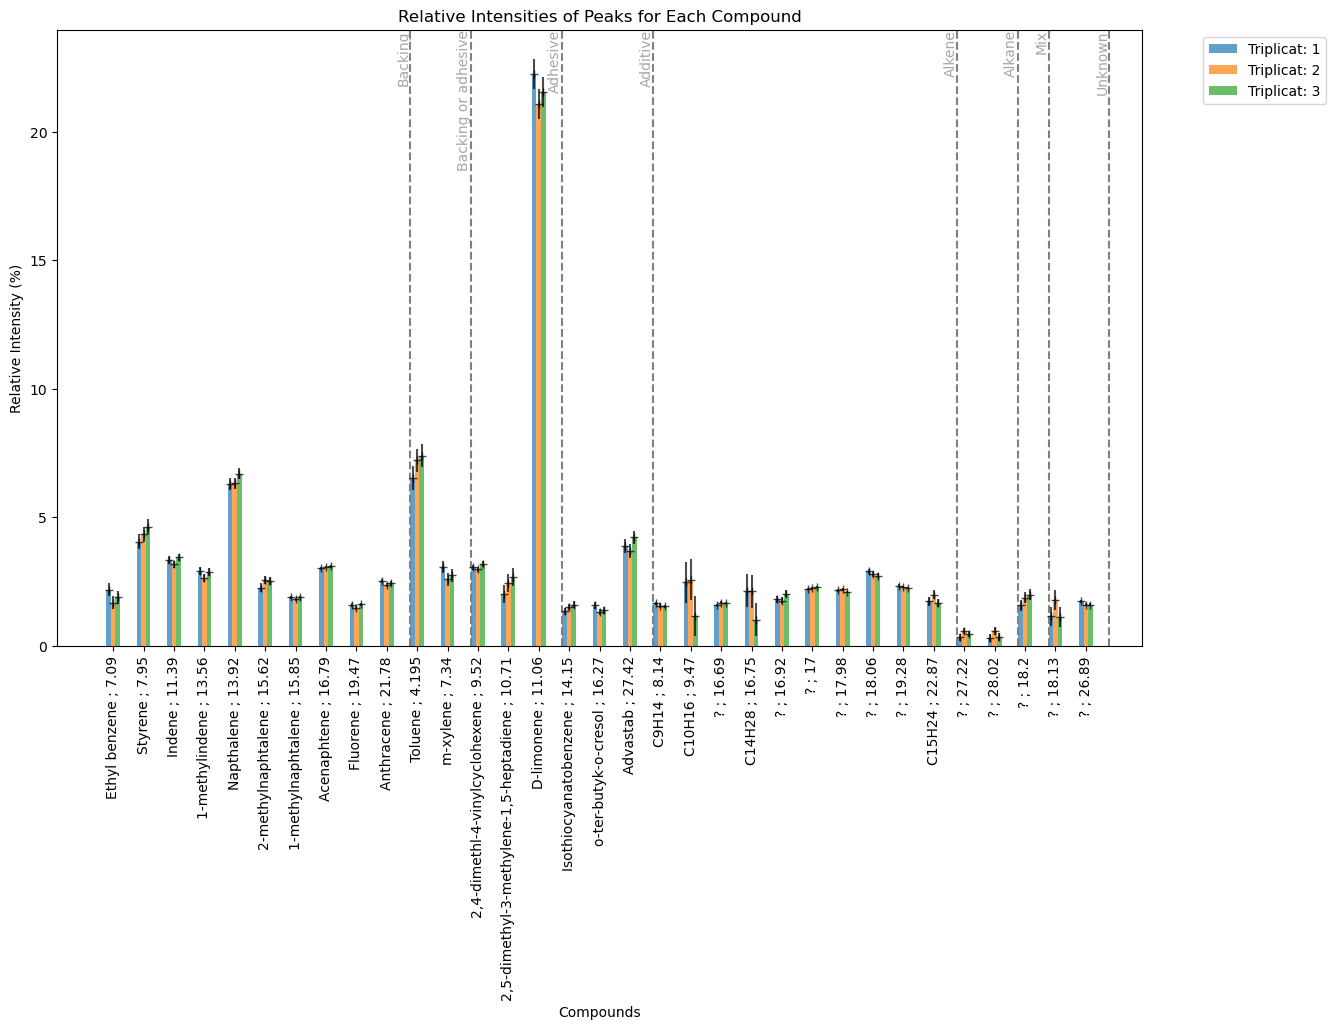

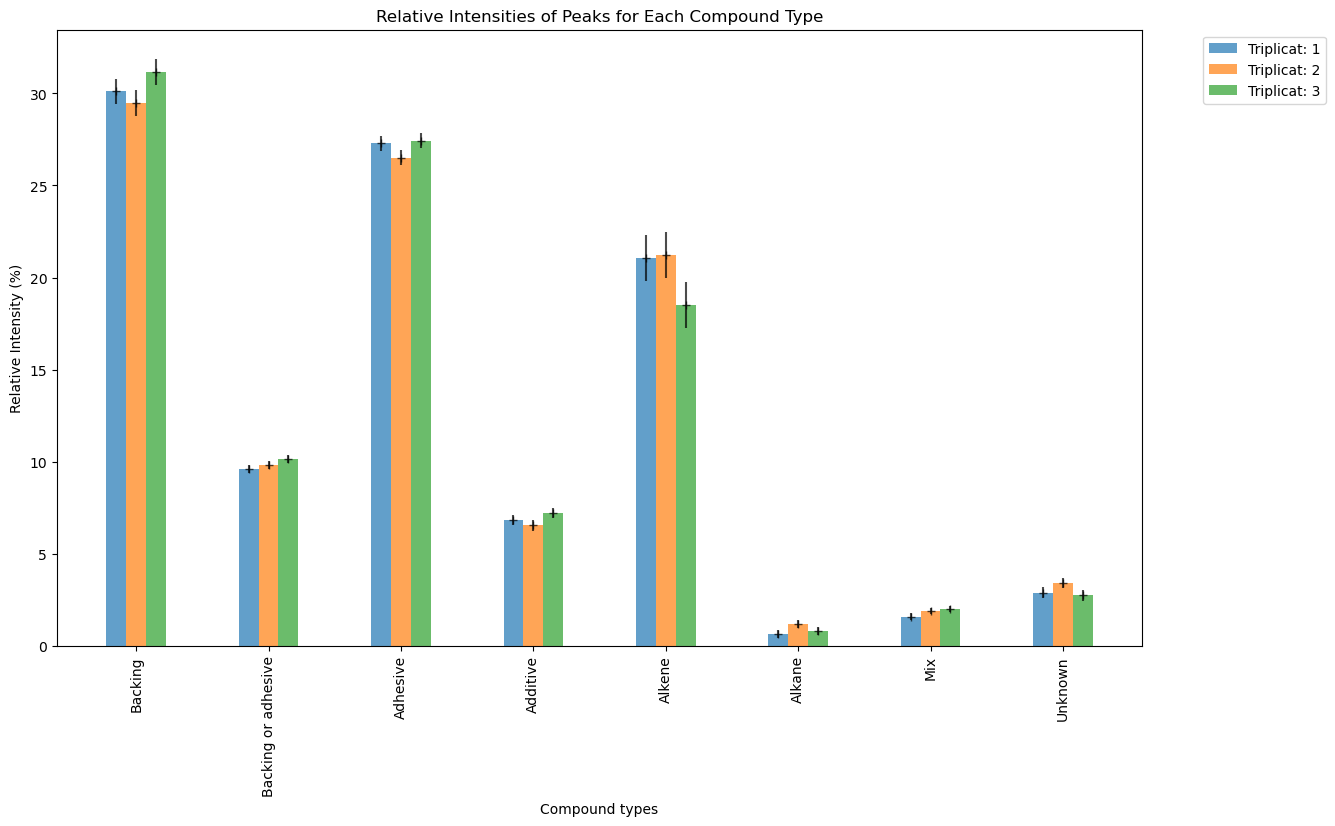

4.195    0.462846
7.09     0.254886
7.34     0.244960
7.95     0.296419
8.14     0.065659
9.47     0.782787
9.52     0.103501
10.71    0.345513
11.06    0.578788
11.39    0.140926
13.56    0.146063
13.92    0.219395
14.15    0.129342
15.62    0.160213
15.85    0.050626
16.27    0.133475
16.69    0.048559
16.75    0.641590
16.79    0.042750
16.92    0.146249
17       0.035208
17.98    0.053882
18.06    0.090803
18.13    0.375166
18.2     0.211933
19.28    0.048296
19.47    0.074285
21.78    0.077533
22.87    0.168966
26.89    0.070666
27.22    0.124041
27.42    0.265103
28.02    0.147489
dtype: float64
Backing                0.696905
Backing or adhesive    0.229167
Adhesive               0.405430
Additive               0.279017
Alkene                 1.251698
Alkane                 0.217595
Mix                    0.173042
Unknown                0.284287
Name: Standard Deviation, dtype: float64


In [21]:
# Représentation des intensités relatives et des écarts types mesurés
raa_type = 'raa12'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()

std_devs = peak_raa_ri_df.iloc[:, 2:].std(axis=0)
compound_type_relative_intensities = {compound_type: [] for compound_type in compound_types_plot}
for compound_type in compound_types_plot:
    relative_intensities = []
    for i in [0,1,2]:
        relative_intensity = 0
        for j, retention_time in enumerate(retention_times):
            if retention_to_compound_type_func(retention_time) == compound_type:
                relative_intensity += peak_raa_ri_df.iloc[i, 2+j]
        relative_intensities.append(relative_intensity)
    compound_type_relative_intensities[compound_type] = relative_intensities
std_devs_by_compound_type = {compound_type: np.std(intensities) for compound_type, intensities in compound_type_relative_intensities.items()}
std_devs_by_compound_type = pd.Series(std_devs_by_compound_type, name='Standard Deviation')

plot_bars_compounds()
plot_bars_compound_types()

print(std_devs)
print(std_devs_by_compound_type)

raa13


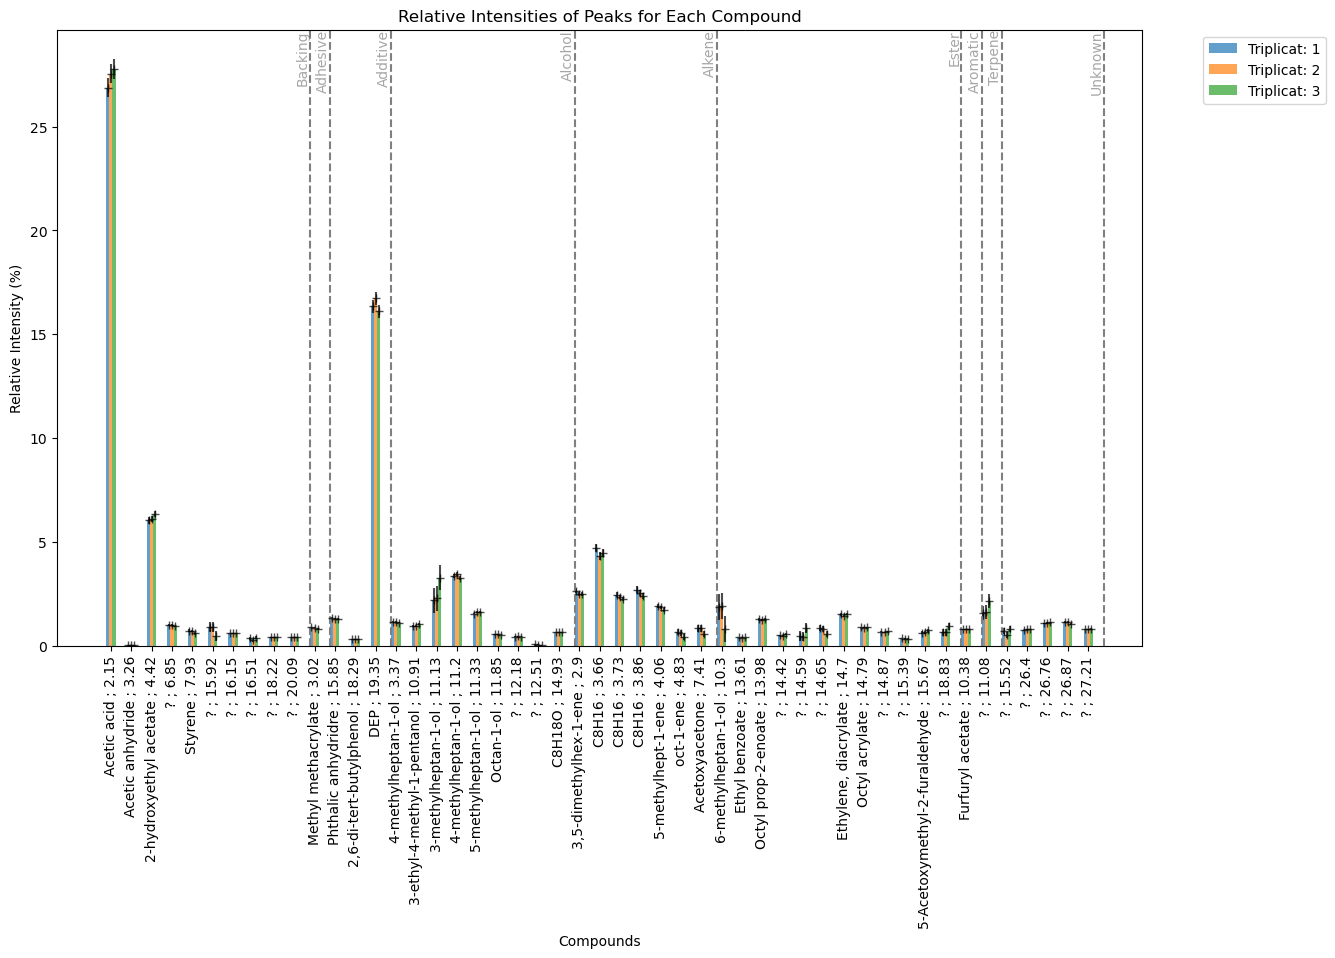

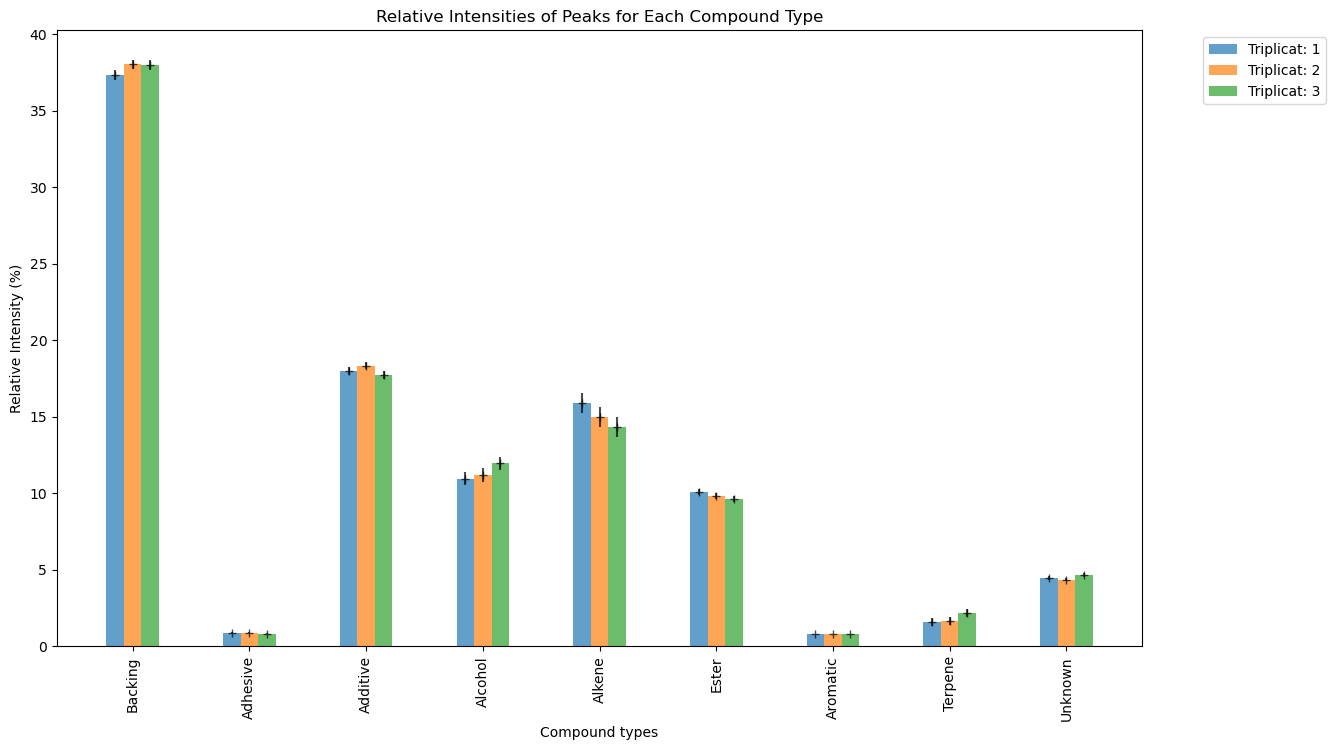

2.15     0.469956
2.9      0.092184
3.02     0.039744
3.26     0.009805
3.37     0.029379
3.66     0.192855
3.73     0.101973
3.86     0.151962
4.06     0.091416
4.42     0.154378
4.83     0.131549
6.85     0.043132
7.41     0.159120
7.93     0.066078
10.3     0.630324
10.38    0.004025
10.91    0.044671
11.08    0.320843
11.13    0.602101
11.2     0.096179
11.33    0.040901
11.85    0.020138
12.18    0.009526
12.51    0.012980
13.61    0.013014
13.98    0.035066
14.42    0.039281
14.59    0.232183
14.65    0.147337
14.7     0.061307
14.79    0.018697
14.87    0.023150
14.93    0.011533
15.39    0.014512
15.52    0.147445
15.67    0.058781
15.85    0.031693
15.92    0.242052
16.15    0.004731
16.51    0.065112
18.22    0.007948
18.29    0.007812
18.83    0.169389
19.35    0.308683
20.09    0.006555
26.4     0.029090
26.76    0.032145
26.87    0.043197
27.21    0.012863
dtype: float64
Backing     0.319418
Adhesive    0.032451
Additive    0.258914
Alcohol     0.429556
Alkene      0.65129

In [22]:
# Représentation des intensités relatives et des écarts types mesurés
raa_type = 'raa13'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()

std_devs = peak_raa_ri_df.iloc[:, 2:].std(axis=0)
compound_type_relative_intensities = {compound_type: [] for compound_type in compound_types_plot}
for compound_type in compound_types_plot:
    relative_intensities = []
    for i in [0,1,2]:
        relative_intensity = 0
        for j, retention_time in enumerate(retention_times):
            if retention_to_compound_type_func(retention_time) == compound_type:
                relative_intensity += peak_raa_ri_df.iloc[i, 2+j]
        relative_intensities.append(relative_intensity)
    compound_type_relative_intensities[compound_type] = relative_intensities
std_devs_by_compound_type = {compound_type: np.std(intensities) for compound_type, intensities in compound_type_relative_intensities.items()}
std_devs_by_compound_type = pd.Series(std_devs_by_compound_type, name='Standard Deviation')

plot_bars_compounds()
plot_bars_compound_types()

print(std_devs)
print(std_devs_by_compound_type)

raa14


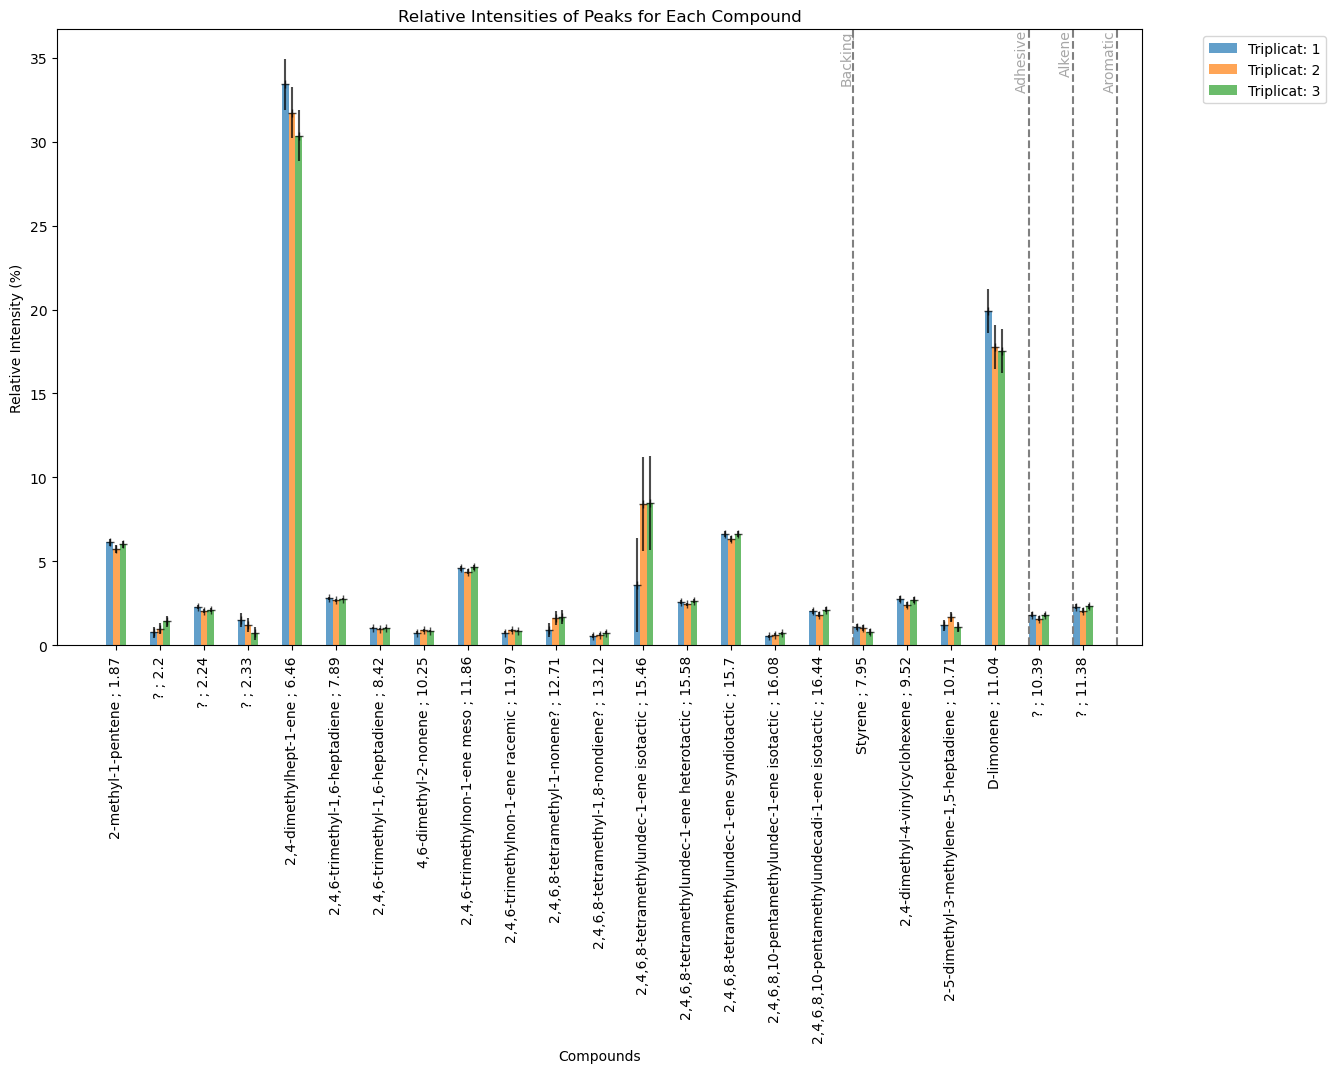

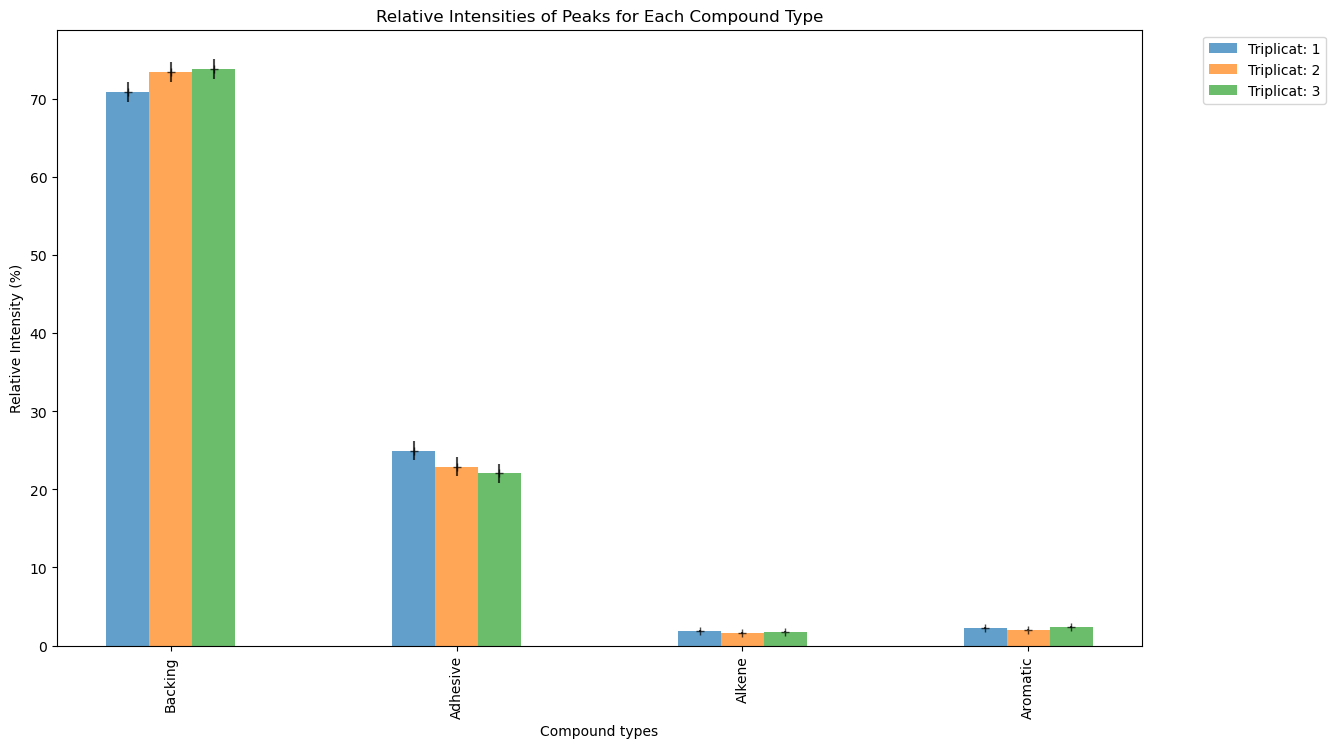

1.87     0.210254
2.2      0.333304
2.24     0.117827
2.33     0.399516
6.46     1.527285
7.89     0.066213
7.95     0.176354
8.42     0.038773
9.52     0.178717
10.25    0.062639
10.39    0.128857
10.71    0.315228
11.04    1.319915
11.38    0.148510
11.86    0.143511
11.97    0.082100
12.71    0.418231
13.12    0.100729
15.46    2.790715
15.58    0.106992
15.7     0.182173
16.08    0.087194
16.44    0.141937
dtype: float64
Backing     1.298287
Adhesive    1.228068
Alkene      0.105212
Aromatic    0.121258
Name: Standard Deviation, dtype: float64


In [23]:
# Représentation des intensités relatives et des écarts types mesurés
raa_type = 'raa14'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()

std_devs = peak_raa_ri_df.iloc[:, 2:].std(axis=0)
compound_type_relative_intensities = {compound_type: [] for compound_type in compound_types_plot}
for compound_type in compound_types_plot:
    relative_intensities = []
    for i in [0,1,2]:
        relative_intensity = 0
        for j, retention_time in enumerate(retention_times):
            if retention_to_compound_type_func(retention_time) == compound_type:
                relative_intensity += peak_raa_ri_df.iloc[i, 2+j]
        relative_intensities.append(relative_intensity)
    compound_type_relative_intensities[compound_type] = relative_intensities
std_devs_by_compound_type = {compound_type: np.std(intensities) for compound_type, intensities in compound_type_relative_intensities.items()}
std_devs_by_compound_type = pd.Series(std_devs_by_compound_type, name='Standard Deviation')

plot_bars_compounds()
plot_bars_compound_types()

print(std_devs)
print(std_devs_by_compound_type)

raa15


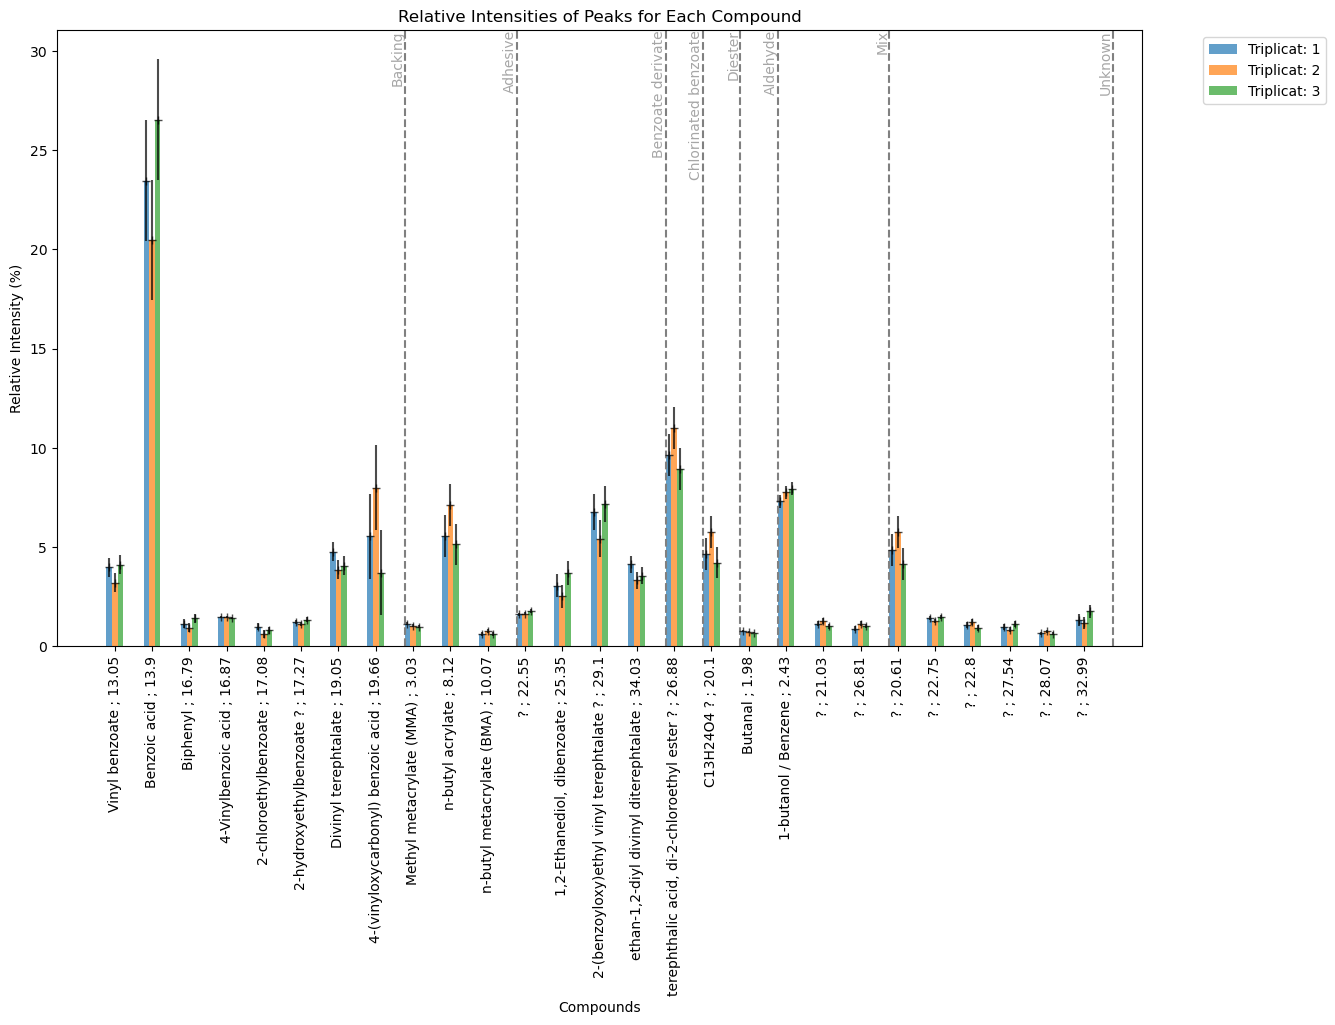

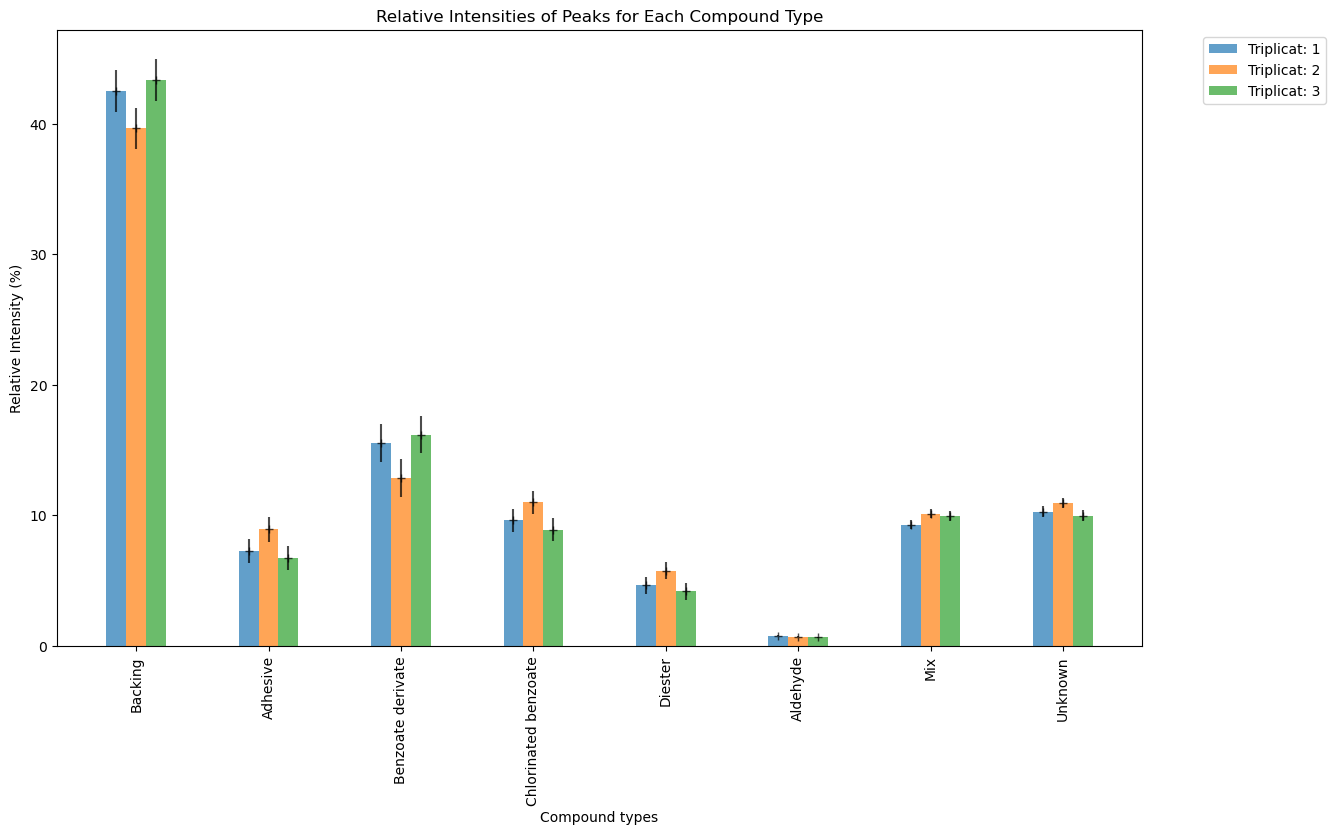

1.98     0.047192
2.43     0.333671
3.03     0.080799
8.12     1.051784
10.07    0.096300
13.05    0.486294
13.9     3.038800
16.79    0.235912
16.87    0.032510
17.08    0.194650
17.27    0.108701
19.05    0.471788
19.66    2.151076
20.1     0.797383
20.61    0.810461
21.03    0.134635
22.55    0.084325
22.75    0.107296
22.8     0.157933
25.35    0.594093
26.81    0.121850
26.88    1.065407
27.54    0.137744
28.07    0.068031
29.1     0.915528
32.99    0.307612
34.03    0.419002
dtype: float64
Backing                 1.589863
Adhesive                0.932062
Benzoate derivate       1.436305
Chlorinated benzoate    0.869901
Diester                 0.651060
Aldehyde                0.038532
Mix                     0.357725
Unknown                 0.407919
Name: Standard Deviation, dtype: float64


In [24]:
# Représentation des intensités relatives et des écarts types mesurés
raa_type = 'raa15'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()

std_devs = peak_raa_ri_df.iloc[:, 2:].std(axis=0)
compound_type_relative_intensities = {compound_type: [] for compound_type in compound_types_plot}
for compound_type in compound_types_plot:
    relative_intensities = []
    for i in [0,1,2]:
        relative_intensity = 0
        for j, retention_time in enumerate(retention_times):
            if retention_to_compound_type_func(retention_time) == compound_type:
                relative_intensity += peak_raa_ri_df.iloc[i, 2+j]
        relative_intensities.append(relative_intensity)
    compound_type_relative_intensities[compound_type] = relative_intensities
std_devs_by_compound_type = {compound_type: np.std(intensities) for compound_type, intensities in compound_type_relative_intensities.items()}
std_devs_by_compound_type = pd.Series(std_devs_by_compound_type, name='Standard Deviation')

plot_bars_compounds()
plot_bars_compound_types()

print(std_devs)
print(std_devs_by_compound_type)

raa16


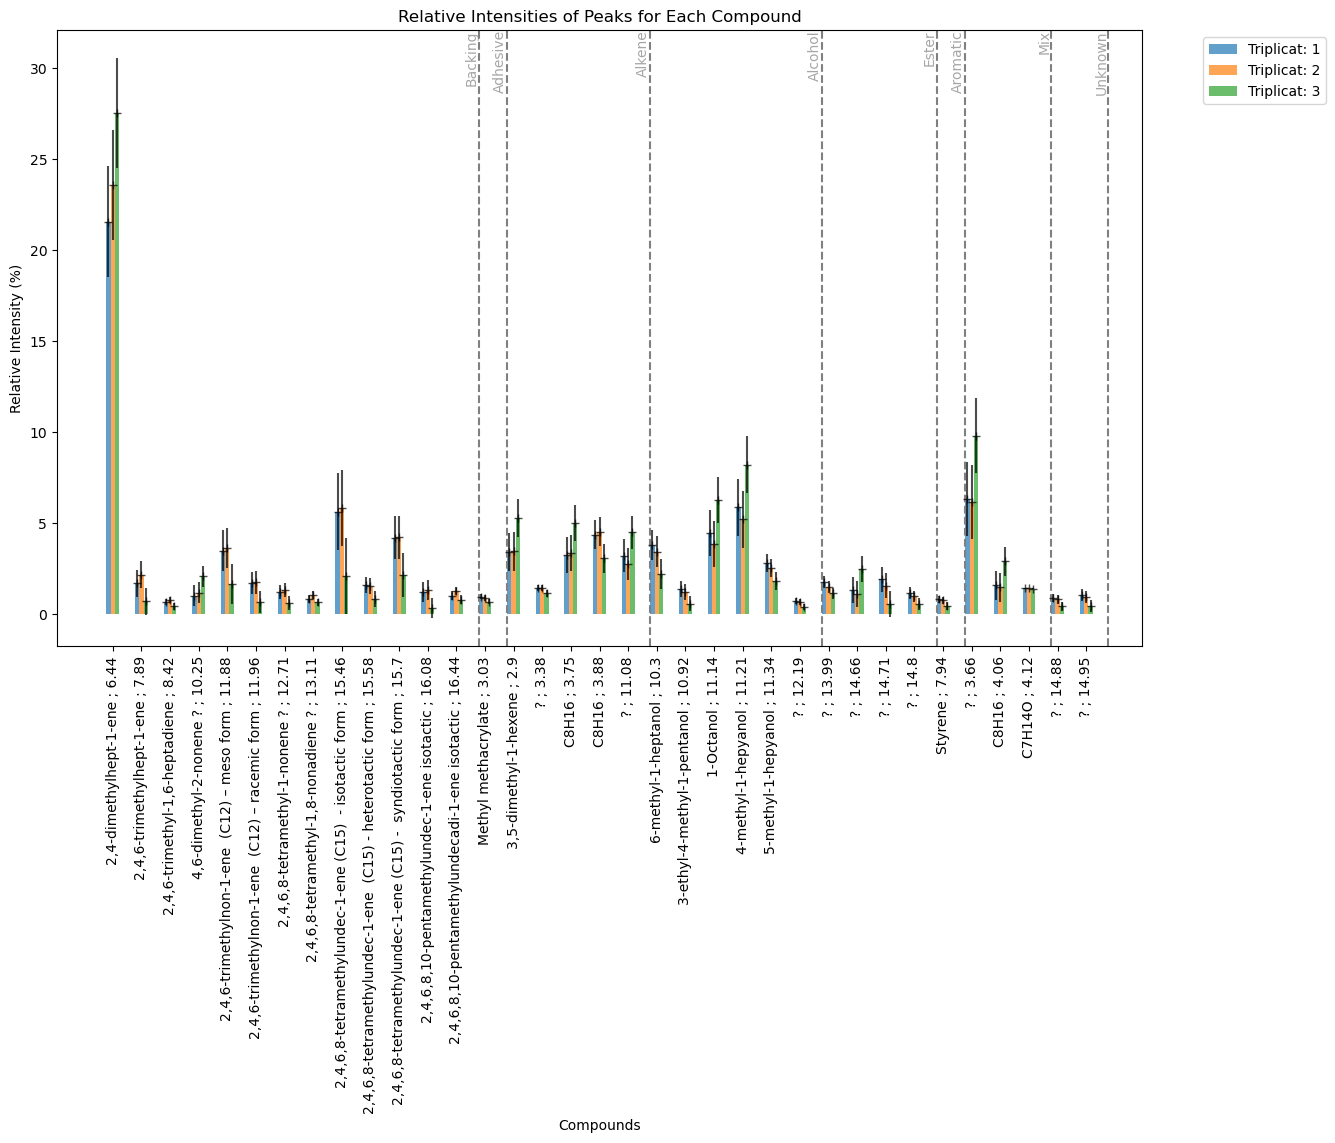

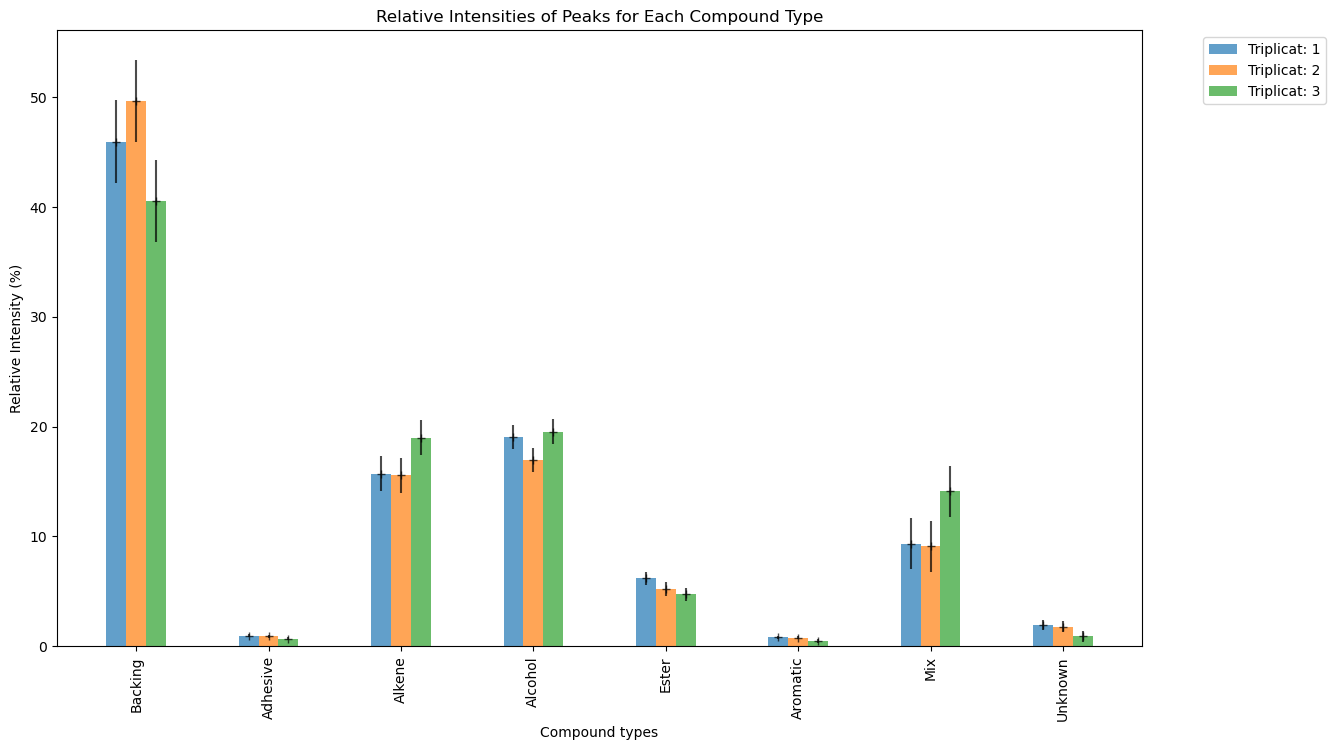

2.9      1.063576
3.03     0.149181
3.38     0.169379
3.66     2.054608
3.75     0.982048
3.88     0.807432
4.06     0.794701
4.12     0.021691
6.44     3.026360
7.89     0.743618
7.94     0.195378
8.42     0.177606
10.25    0.577758
10.3     0.832335
10.92    0.418531
11.08    0.897617
11.14    1.261204
11.21    1.568277
11.34    0.508021
11.88    1.108966
11.96    0.613379
12.19    0.166345
12.71    0.393517
13.11    0.205493
13.99    0.312157
14.66    0.714927
14.71    0.705523
14.8     0.310688
14.88    0.243463
14.95    0.327904
15.46    2.103595
15.58    0.425090
15.7     1.195476
16.08    0.549493
16.44    0.240432
dtype: float64
Backing     3.747568
Adhesive    0.121806
Alkene      1.585582
Alcohol     1.118703
Ester       0.603745
Aromatic    0.159526
Mix         2.310597
Unknown     0.466500
Name: Standard Deviation, dtype: float64


In [25]:
# Représentation des intensités relatives et des écarts types mesurés
raa_type = 'raa16'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()

std_devs = peak_raa_ri_df.iloc[:, 2:].std(axis=0)
compound_type_relative_intensities = {compound_type: [] for compound_type in compound_types_plot}
for compound_type in compound_types_plot:
    relative_intensities = []
    for i in [0,1,2]:
        relative_intensity = 0
        for j, retention_time in enumerate(retention_times):
            if retention_to_compound_type_func(retention_time) == compound_type:
                relative_intensity += peak_raa_ri_df.iloc[i, 2+j]
        relative_intensities.append(relative_intensity)
    compound_type_relative_intensities[compound_type] = relative_intensities
std_devs_by_compound_type = {compound_type: np.std(intensities) for compound_type, intensities in compound_type_relative_intensities.items()}
std_devs_by_compound_type = pd.Series(std_devs_by_compound_type, name='Standard Deviation')

plot_bars_compounds()
plot_bars_compound_types()

print(std_devs)
print(std_devs_by_compound_type)